# initialize env 

In [23]:
%cd /content/drive/My Drive/FDS/

/content/drive/My Drive/FDS


In [24]:
# import module

import os
import librosa, librosa.display
import math
import json
import matplotlib.pyplot as plt
import numpy as np

In [25]:
# path module

CURRENT_DIR = os.path.abspath(os.getcwd())
DATASET_PATH = os.path.join(os.path.join(CURRENT_DIR, "Data"), "genres_original")
# JSON_PATH = os.path.join(os.path.join(CURRENT_DIR, "JSON"), "data.json")
JSON_PATH = './data.json'
SAMPLE_PATH = os.path.join(os.path.join(DATASET_PATH,"blues"), "blues.00000.wav")

# preprocessing 

In [ ]:
SAMPLE_RATE = 22050
DURATION = 30 # seconds
SAMPLES_PER_TRACK = SAMPLE_RATE * DURATION

def save_mfcc(dataset_path, json_path, n_mfcc=13, n_fft=2048, hop_length=512, num_segments=5):
    # dictionary to store data
    data = {
        "mapping":[],
        "mfcc":[],
        "labels":[]
    }

    num_samples_per_segment = int(SAMPLES_PER_TRACK / num_segments)
    expected_num_mfcc_vectors_per_segment = math.ceil(num_samples_per_segment / hop_length)

    # loop through all the genres
    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):
        # ensure that we're not at the root level
        if dirpath is not dataset_path:
            # save the semantic label
            dirpath_components = dirpath.split("\\")
            semantic_label = dirpath_components[-1]
            data["mapping"].append(semantic_label)
            print("\nProcessing {}".format(semantic_label))

            # process files for a specific genre
            for file in filenames:
                # load audio file
                file_path = os.path.join(dirpath, file)
                try:
                    signal, sr = librosa.load(file_path, sr=SAMPLE_RATE)

                    # process segments extracting mfcc and storing data
                    for s in range(num_segments):
                        start_sample = num_samples_per_segment * s
                        finish_sample = start_sample + num_samples_per_segment

                        mfcc = librosa.feature.mfcc(signal[start_sample:finish_sample],
                                                sr=sr,
                                                n_fft = n_fft,
                                                n_mfcc=n_mfcc,
                                                hop_length=hop_length)

                        mfcc = mfcc.T

                        # store mfcc for segment if it has the expected length
                        if len(mfcc) == expected_num_mfcc_vectors_per_segment:
                            data["mfcc"].append(mfcc.tolist())
                            data["labels"].append(i-1)

                except Exception as ex:
                    print("An error occurred")
                    print(i)
                    pass

    return data



In [ ]:
%%time
data = save_mfcc(DATASET_PATH, JSON_PATH, num_segments=10)


Processing /content/drive/My Drive/FDS/Data/genres_original/rock

Processing /content/drive/My Drive/FDS/Data/genres_original/classical

Processing /content/drive/My Drive/FDS/Data/genres_original/reggae

Processing /content/drive/My Drive/FDS/Data/genres_original/blues

Processing /content/drive/My Drive/FDS/Data/genres_original/metal

Processing /content/drive/My Drive/FDS/Data/genres_original/disco

Processing /content/drive/My Drive/FDS/Data/genres_original/pop

Processing /content/drive/My Drive/FDS/Data/genres_original/country

Processing /content/drive/My Drive/FDS/Data/genres_original/jazz
An error occurred
9

Processing /content/drive/My Drive/FDS/Data/genres_original/hiphop
CPU times: user 3min 44s, sys: 2min 56s, total: 6min 41s
Wall time: 6min


In [ ]:
 with open('./data.json', "w") as fp:
        json.dump(data, fp, indent=4)

In [22]:

# from keras import backend as K
# from keras.constraints import Constraint
# import matplotlib.pyplot as plt
# import tensorflow.keras as keras
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import classification_report




class Sparse(Constraint):
    def __init__(self, mask):
        self.mask = mask  
    def __call__(self,x):
        return self.mask * x   
    def get_config(self):
        return {'mask': self.mask}

a = Sparse()
a(10)

1.0

# model - aggiungi

In [27]:
import matplotlib.pyplot as plt
import tensorflow.keras as keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report




# plot accuracy and error over the epochs
def plot_history(history):
    fig, axs = plt.subplots(2)

    # create accuracy subplot
    axs[0].plot(history.history["accuracy"], label="Train Accuracy")
    axs[0].plot(history.history["val_accuracy"], label="Test Accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    # axs[0].set_title("Accuracy Eval")

    # create error subplot
    axs[1].plot(history.history["loss"], label="Train Error")
    axs[1].plot(history.history["val_loss"], label="Test Error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    # axs[1].set_title("Error Eval")

    plt.show()


# load data
def load_data(dataset_path):
    with open(dataset_path, "r") as fp:
        data = json.load(fp)

    # convert lists into numpy arrays
    inputs = np.array(data["mfcc"])
    targets = np.array(data["labels"])

    return inputs, targets



from keras import backend as K
from keras.constraints import Constraint

class Sparse(Constraint):
    def __init__(self, mask):
        self.mask = K.cast_to_floatx(mask)  
    def __call__(self,x):
        return self.mask * x   
    def get_config(self):
        return {'mask': self.mask}


def keep_good_weights(model, sparsity = 30):
    weights = model.get_weights()
    good_weights = []
    for weight in weights:
        if len(weight.shape) > 1:
            weight = np.abs(weight)
            good_weights.append( weight > np.percentile(weight, sparsity) )
    return good_weights




def build_initial_MLP(inputs):
    model = keras.Sequential([                          
                  keras.layers.Flatten(input_shape=(inputs.shape[1], inputs.shape[2])),
                  keras.layers.Dense(units = 500, 
                                    activation="relu", 
                                    kernel_regularizer=keras.regularizers.l2(0.01)),
                  keras.layers.Dropout(0.1),

                  keras.layers.Dense( units = 400, 
                                    activation="relu", 
                                    kernel_regularizer=keras.regularizers.l2(0.01)
                                    ),
                  keras.layers.Dropout(0.25),

                  keras.layers.Dense( units = 300, 
                                    activation="relu", 
                                    kernel_regularizer=keras.regularizers.l2(0.01)
                                    ),
                  keras.layers.Dropout(0.25),

                  keras.layers.Dense(units = 200, 
                                    activation="relu", 
                                    kernel_regularizer=keras.regularizers.l2(0.01)),
                  keras.layers.Dropout(0.5),

                  keras.layers.Dense(units = 100, 
                                    activation="relu",
                                    kernel_regularizer=keras.regularizers.l2(0.01)),
                  keras.layers.Dropout(0.5),    

                  keras.layers.Dense(units = 10, activation="softmax")
                  ])
    return model 
  


def build_sparse_MLP(inputs, sparse_weights):
    model = keras.Sequential([                          
                  keras.layers.Flatten( input_shape=(inputs.shape[1], inputs.shape[2])),

                  keras.layers.Dense(units = 500, 
                                    activation = "relu", 
                                    kernel_regularizer = keras.regularizers.l2(0.01),
                                    kernel_constraint = Sparse(sparse_weights[0]) 
                                    ),
                  keras.layers.Dropout(0.1),

                  keras.layers.Dense( units = 400, 
                                    activation="relu", 
                                    kernel_regularizer=keras.regularizers.l2(0.01),
                                    kernel_constraint = Sparse(sparse_weights[1])
                                    ),
                  keras.layers.Dropout(0.25),

                  keras.layers.Dense( units = 300, 
                                    activation="relu", 
                                    kernel_regularizer=keras.regularizers.l2(0.01),
                                    kernel_constraint = Sparse(sparse_weights[2])
                                    ),
                  keras.layers.Dropout(0.25),

                  keras.layers.Dense( units = 200, 
                                    activation="relu", 
                                    kernel_regularizer=keras.regularizers.l2(0.01),
                                    kernel_constraint = Sparse(sparse_weights[3])
                                    ),
                  keras.layers.Dropout(0.5),

                  keras.layers.Dense(units = 100, 
                                    activation="relu",
                                    kernel_regularizer=keras.regularizers.l2(0.01),
                                    kernel_constraint = Sparse(sparse_weights[4]) 
                                    ),
                  keras.layers.Dropout(0.5),

                  keras.layers.Dense(units = 10, activation="softmax")
                  ])
    return model 


def build_final_MLP(inputs):
    model = keras.Sequential([                          
                  keras.layers.Flatten( input_shape=(inputs.shape[1], inputs.shape[2])),

                  keras.layers.Dense(units = 500, 
                                    activation="relu", 
                                    kernel_regularizer=keras.regularizers.l2(0.01)),
                  keras.layers.Dropout(0.1),

                  keras.layers.Dense(units = 400, 
                                    activation="relu", 
                                    kernel_regularizer=keras.regularizers.l2(0.01)
                                    ),
                  keras.layers.Dropout(0.25),

                  keras.layers.Dense(units = 300, 
                                    activation="relu", 
                                    kernel_regularizer=keras.regularizers.l2(0.01)
                                    ),
                  keras.layers.Dropout(0.25),

                  keras.layers.Dense(units = 200, 
                                    activation="relu", 
                                    kernel_regularizer=keras.regularizers.l2(0.01)),
                  keras.layers.Dropout(0.5),

                  keras.layers.Dense(units = 100, 
                                    activation="relu",
                                    kernel_regularizer=keras.regularizers.l2(0.01)),
                  keras.layers.Dropout(0.5),

                  keras.layers.Dense(units = 10, activation="softmax")
                  ])
    return model 

def prepare_datasets(test_size, validation_size, dataset_path):
    # load data
    X, y = load_data(dataset_path)
    # create train/test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    # create train/validation split
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_size)
    return X_train, X_validation, X_test, y_train, y_validation, y_test


def get_classification_report(model, X, y):
    prediction = model.predict_classes(X)
    return classification_report(y_true = y, y_pred = prediction)

def test_MLP(model, X_test, y_test):
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=2)
    return test_loss, test_accuracy

def compile_MLP(model):
    optimizer = keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer= optimizer,
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])

#learning rate is 1/10 of the initial model
def compile_final_dense_MLP(model):
    optimizer = keras.optimizers.Adam(learning_rate=0.00001)
    model.compile(optimizer= optimizer,
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])

def train_MLP(model, X_train, X_validation, y_train, y_validation):
    callback = keras.callbacks.EarlyStopping(monitor='val_loss',  patience=5, mode='auto')
    trained_model = model.fit(X_train, 
                              y_train,
                              validation_data = (X_validation, y_validation),
                              epochs=200,
                              batch_size=32,
                              callbacks=[callback], 
                              verbose = 2)
    return trained_model


def initial_dense_multi_layer_perceptron(dataset_path):

    X_train, X_validation, X_test, y_train, y_validation, y_test = prepare_datasets(0.25, 0.2, dataset_path)
    model = build_initial_MLP(X_train)
    compile_MLP(model)
    history = train_MLP(model, X_train, X_validation, y_train, y_validation)
    test_loss, test_accuracy = test_MLP(model, X_test, y_test)   
    report = get_classification_report(model, X_test, y_test) 

    return history, test_loss, test_accuracy, report, model


def sparse_multi_layer_perceptron(dataset_path, prev_model):

    X_train, X_validation, X_test, y_train, y_validation, y_test = prepare_datasets(0.25, 0.2, dataset_path)
    sparse_model = build_sparse_MLP(X_train, keep_good_weights(prev_model))
    compile_MLP(sparse_model)
    sparse_model.set_weights(prev_model.get_weights())
    history = train_MLP(sparse_model, X_train, X_validation, y_train, y_validation)
    test_loss, test_accuracy = test_MLP(sparse_model, X_test, y_test)   
    report = get_classification_report(sparse_model, X_test, y_test) 
    
    return history, test_loss, test_accuracy, report, sparse_model

def final_dense_multi_layer_perceptron(dataset_path, prev_model):

    X_train, X_validation, X_test, y_train, y_validation, y_test = prepare_datasets(0.25, 0.2, dataset_path)
    model = build_final_MLP(X_train)
    compile_final_dense_MLP(model)
    model.set_weights(prev_model.get_weights())
    history = train_MLP(model, X_train, X_validation, y_train, y_validation)
    test_loss, test_accuracy = test_MLP(model, X_test, y_test)   
    report = get_classification_report(model, X_test, y_test) 
    
    return history, test_loss, test_accuracy, report, model


In [ ]:
%%time
history, test_loss, test_accuracy, report, initial_dense_model = initial_dense_multi_layer_perceptron(JSON_PATH)

In [ ]:
%%time
sparse_history, sparse_test_loss, sparse_test_accuracy, sparse_report, sparse_model = sparse_multi_layer_perceptron(JSON_PATH, initial_dense_model)

final dense 

In [ ]:
%%time
final_trained_model, final_test_loss, final_test_accuracy, final_report, final_model = final_dense_multi_layer_perceptron(JSON_PATH, sparse_model)

In [ ]:
print("Accuracy on test set is: {}".format(final_test_accuracy))
print("Loss on test set is: {}".format(final_test_loss))
print(final_report)

Accuracy on test set is: 0.8285943269729614
Loss on test set is: 1.238424301147461
              precision    recall  f1-score   support

           0       0.70      0.71      0.70       255
           1       0.89      0.92      0.90       261
           2       0.91      0.85      0.88       266
           3       0.73      0.84      0.78       233
           4       0.94      0.86      0.90       281
           5       0.85      0.85      0.85       249
           6       0.94      0.92      0.93       262
           7       0.66      0.74      0.70       239
           8       0.75      0.73      0.74       237
           9       0.94      0.85      0.89       214

    accuracy                           0.83      2497
   macro avg       0.83      0.83      0.83      2497
weighted avg       0.83      0.83      0.83      2497



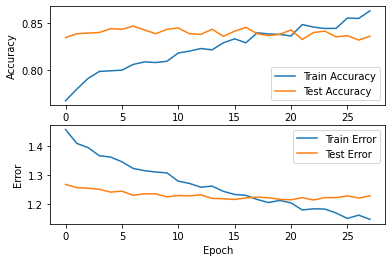

In [ ]:
plot_history(final_trained_model)